In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2025-04-09 21:04:54.787345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 21:04:57.293132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744225498.213417  491585 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744225498.476260  491585 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744225500.678755  491585 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found GPU at: /device:GPU:0


I0000 00:00:1744225541.405922  491585 gpu_device.cc:2019] Created device /device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
train_ds, train_info = tfds.load('speech_commands', split='train', shuffle_files=True, as_supervised=True, with_info=True)
val_ds, val_info = tfds.load('speech_commands', split='validation', shuffle_files=True, as_supervised=True, with_info=True)
test_ds, test_info = tfds.load('speech_commands', split='test', shuffle_files=True, as_supervised=True, with_info=True)

I0000 00:00:1744225544.132674  491585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
for example in train_ds.take(1):
    print(example)

(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([  0,  -2,  -1, ..., -14, -17, -20], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=11>)


2025-04-09 21:05:44.742799: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-09 21:05:44.796849: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
class_names = train_info.features['label'].names
print("Original class names:", class_names)

Original class names: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [6]:
labels = [example[1] for example in train_ds]
print(len(labels))

85511


2025-04-09 21:05:58.583712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


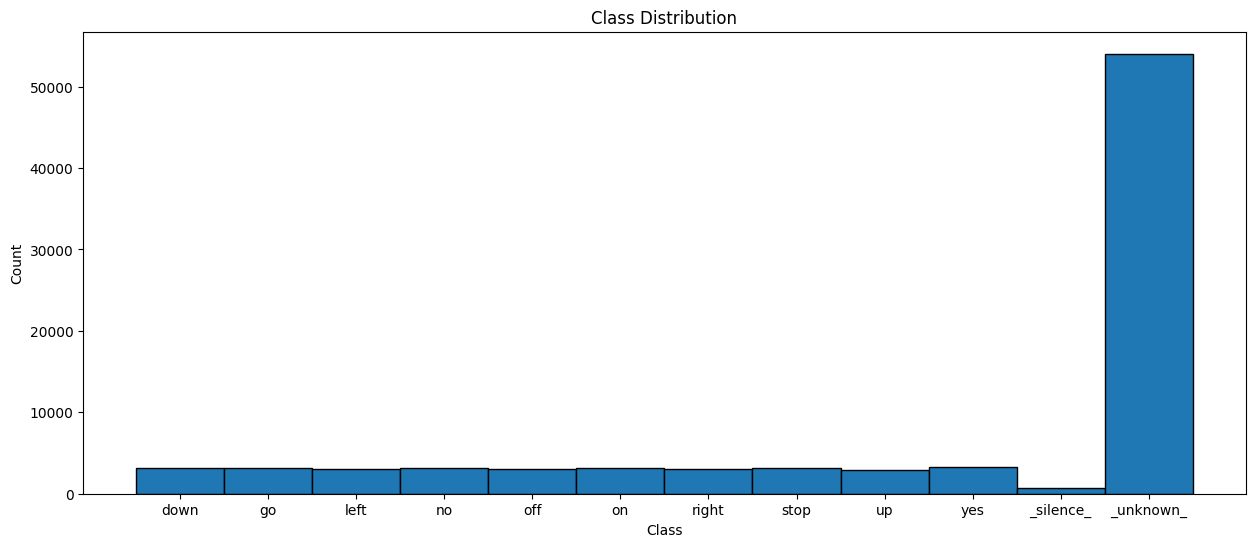

In [7]:
print(class_names)
n_classes = len(class_names)
bin_edges = np.arange(-0.5, n_classes)

plt.figure(figsize=(15, 6))
plt.hist(labels, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(len(class_names)), labels=class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
new_label_indexes = [0, 2, 6, 8, 10, 11] 
labels_to_keep = tf.constant(new_label_indexes, dtype=tf.int64)
new_class_names = ['down', 'left', 'right', 'up', '_silence_', '_unknown_']
n_classes = len(new_class_names)

filtered_train_ds = train_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

In [ ]:
label_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(new_label_indexes, dtype=tf.int64),
        values=tf.constant(list(range(len(new_label_indexes))), dtype=tf.int64)
    ),
    default_value=-1  
)

def remap_labels(audio, label):
    new_label = label_mapping.lookup(label)
    return audio, new_label

remapped_train_ds = filtered_train_ds.map(remap_labels)

In [ ]:
new_labels = []
for _, label in remapped_train_ds:
    new_labels.append(label.numpy())  

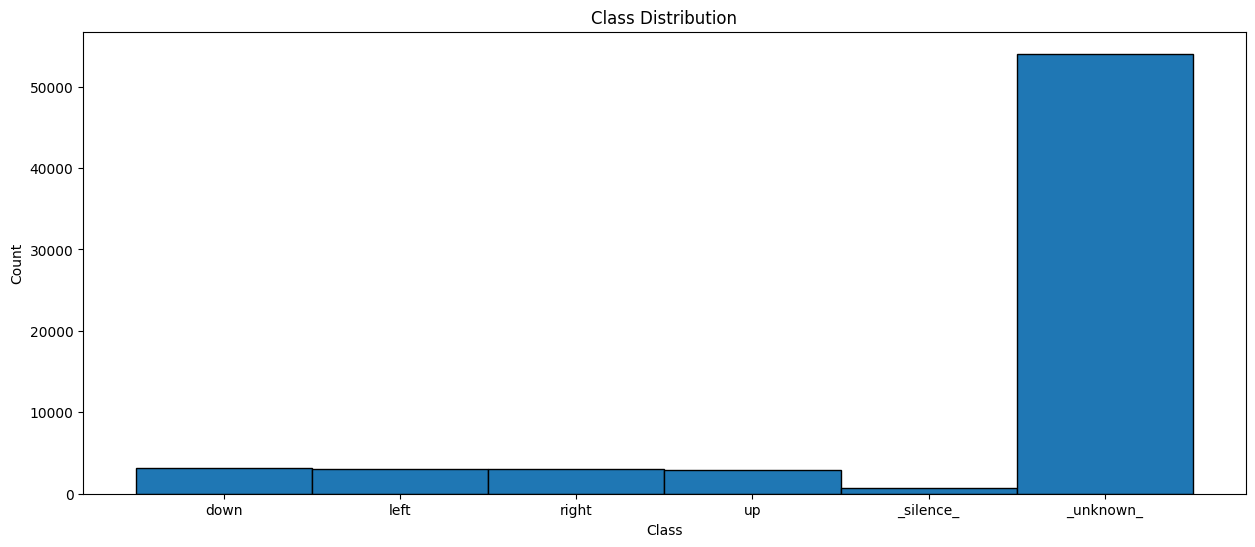

In [ ]:
bin_edges = np.arange(-0.5, n_classes)  
plt.figure(figsize=(15, 6))
plt.hist(new_labels, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(n_classes), labels=new_class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [12]:
filtered_val_ds = val_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

filtered_test_ds = test_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

remapped_val_ds = filtered_val_ds.map(remap_labels)
remapped_test_ds = filtered_test_ds.map(remap_labels)

In [ ]:
import IPython.display as ipd  

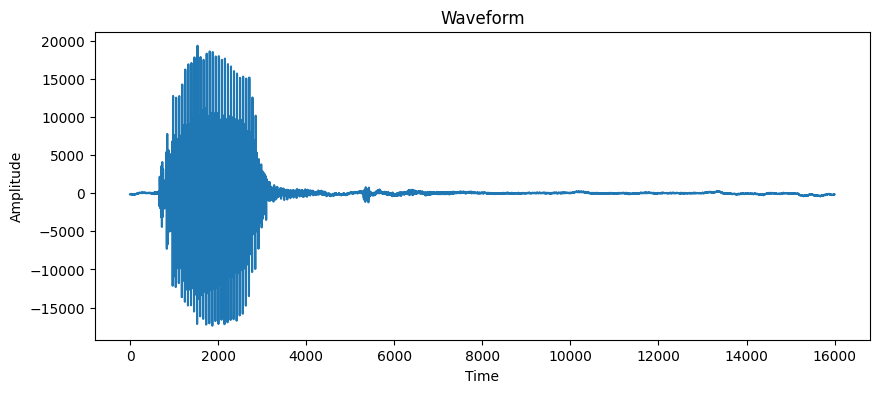

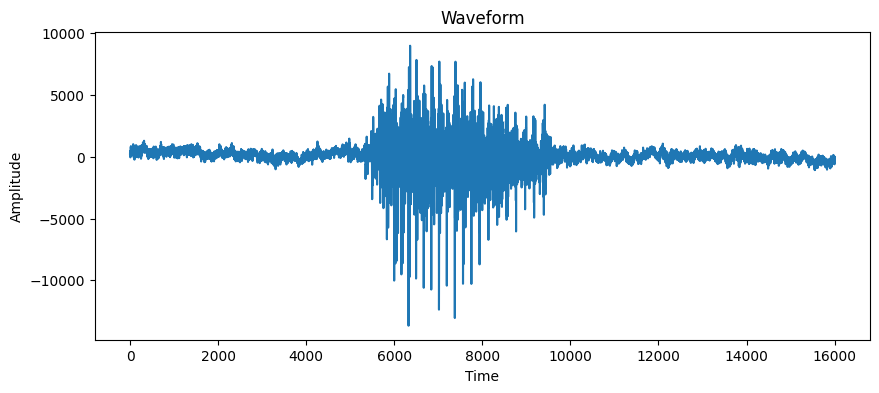

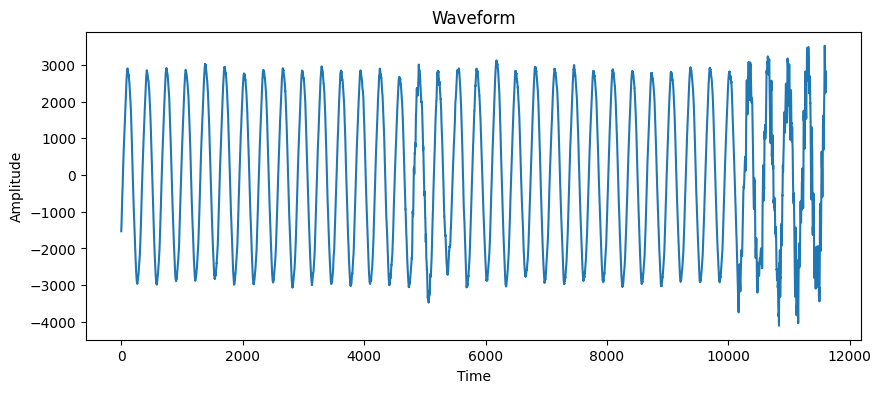

2025-04-09 21:06:13.806299: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for example in train_ds.take(3):
  audio = example[0].numpy()
  sample_rate = train_info.features['audio'].sample_rate

  ipd.display(ipd.Audio(audio, rate=sample_rate))

  plt.figure(figsize=(10, 4))
  plt.plot(audio)
  plt.title("Waveform")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

In [15]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Input layer matching the spectrogram shape
        tf.keras.layers.Input(shape=input_shape),
        
        # CNN layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers - use GlobalAveragePooling2D to avoid reshape issues
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def preprocess_dataset(dataset, target_class_ids):
    def preprocess(audio, label):
        audio = tf.cast(audio, tf.float32)
        target_length = 16000
        
        current_length = tf.shape(audio)[0]
        pad_begin = 0
        pad_end = tf.maximum(0, target_length - current_length)
        
        paddings = [[pad_begin, pad_end]]
        audio = tf.pad(audio, paddings)
        
        audio = audio[:target_length]
        
        spectrogram = tf.abs(tf.signal.stft(
            audio, frame_length=256, frame_step=128))
        
        spectrogram = tf.expand_dims(spectrogram, -1)
        
        label_index = tf.argmax(tf.equal(label, target_class_ids))
        one_hot = tf.one_hot(label_index, depth=len(target_class_ids))
            
        return spectrogram, one_hot
    
    return dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
def inspect_dataset(dataset):
    for spectrogram, label in dataset.take(1):
        print(f"Spectrogram shape: {spectrogram.shape}")
        print(f"Label shape: {label.shape}")
    return spectrogram.shape[1:] 


In [ ]:
target_class_ids = [class_names.index(cls) for cls in class_names]
preprocessed_train_ds = preprocess_dataset(remapped_train_ds, target_class_ids).batch(32).prefetch(tf.data.AUTOTUNE)
preprocessed_val_ds = preprocess_dataset(remapped_val_ds, target_class_ids).batch(32)
preprocessed_test_ds = preprocess_dataset(remapped_test_ds, target_class_ids).batch(32)

input_shape = inspect_dataset(preprocessed_train_ds)
print(f"Using input shape: {input_shape}")

model = create_model(input_shape, len(class_names))
model.summary()  
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    preprocessed_train_ds,
    validation_data=preprocessed_val_ds,
    epochs=30,
    callbacks=callbacks
)

Spectrogram shape: (32, 124, 129, 1)
Label shape: (32, 12)
Using input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 129, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 129, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,676 (506.55 KB)

 Trainable params: 129,228 (504.80 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30


I0000 00:00:1744225577.281698  492532 service.cc:152] XLA service 0x7facf8010e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744225577.281746  492532 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-04-09 21:06:17.564650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744225577.960890  492532 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-09 21:06:19.032259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1476', 12 bytes spill stores, 16 bytes spill loads

2025-04-09 21:06:19.376033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

     23/Unknown 11s 7ms/step - accuracy: 0.6039 - loss: 1.7018

I0000 00:00:1744225586.837450  492532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2088/Unknown 25s 7ms/step - accuracy: 0.8367 - loss: 0.5791

2025-04-09 21:06:40.993588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:06:40.993642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173
/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-09 21:06:41.578963: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167', 4 bytes spill stores, 4 bytes spill loads



2090/2090 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.8367 - loss: 0.5788 - val_accuracy: 0.9106 - val_loss: 0.2462
Epoch 2/30
   1/2090 ━━━━━━━━━━━━━━━━━━━━ 2:14 64ms/step - accuracy: 0.9688 - loss: 0.1705

2025-04-09 21:06:41.858273: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-09 21:06:41.858311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:06:41.858338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2088/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9361 - loss: 0.1989

2025-04-09 21:06:56.193420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:06:56.193475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9361 - loss: 0.1988 - val_accuracy: 0.9432 - val_loss: 0.1896
Epoch 3/30
   7/2090 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9589 - loss: 0.1269  

2025-04-09 21:06:57.669722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:06:57.669778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


1422/2090 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9522 - loss: 0.1472

2087/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9524 - loss: 0.1468

2025-04-09 21:07:11.862553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:11.862650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9524 - loss: 0.1468 - val_accuracy: 0.9462 - val_loss: 0.1639
Epoch 4/30
   7/2090 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9798 - loss: 0.0788  

2025-04-09 21:07:10.473482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-09 21:07:10.473522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:10.473548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9607 - loss: 0.1218

2025-04-09 21:07:24.614611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:24.614710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9607 - loss: 0.1218 - val_accuracy: 0.9263 - val_loss: 0.2173
Epoch 5/30
  10/2090 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9651 - loss: 0.0965

2025-04-09 21:07:26.197870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:26.197927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9648 - loss: 0.1108

2025-04-09 21:07:40.673965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:40.674022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9648 - loss: 0.1108 - val_accuracy: 0.9443 - val_loss: 0.1802
Epoch 6/30
   9/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9784 - loss: 0.0578  

2025-04-09 21:07:39.319480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:39.319538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2088/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9673 - loss: 0.1010

2025-04-09 21:07:53.464762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:53.464819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9673 - loss: 0.1010 - val_accuracy: 0.9278 - val_loss: 0.2417
Epoch 7/30
  14/2090 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9894 - loss: 0.0476 

2025-04-09 21:07:54.949321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:07:54.949377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2088/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9707 - loss: 0.0894

2025-04-09 21:08:09.351403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:09.351499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9707 - loss: 0.0894 - val_accuracy: 0.9577 - val_loss: 0.1390
Epoch 8/30
   1/2090 ━━━━━━━━━━━━━━━━━━━━ 2:13 64ms/step - accuracy: 0.9688 - loss: 0.1828

2025-04-09 21:08:10.807256: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-09 21:08:10.807293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:10.807318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9728 - loss: 0.0808

2025-04-09 21:08:24.956118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:24.956172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9728 - loss: 0.0808 - val_accuracy: 0.9615 - val_loss: 0.1266
Epoch 9/30
   8/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9895 - loss: 0.0500  

2025-04-09 21:08:26.493591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:26.493647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2013/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9754 - loss: 0.0762

2025-04-09 21:08:37.956757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:37.956859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9754 - loss: 0.0762 - val_accuracy: 0.9691 - val_loss: 0.1068
Epoch 10/30
   9/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9601 - loss: 0.0955  

2025-04-09 21:08:39.517810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:39.517866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2085/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9787 - loss: 0.0677

2025-04-09 21:08:53.823557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:53.823663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9787 - loss: 0.0677 - val_accuracy: 0.9644 - val_loss: 0.1232
Epoch 11/30
  17/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9802 - loss: 0.0522 

2025-04-09 21:08:55.378097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:08:55.378154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2087/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9796 - loss: 0.0630

2025-04-09 21:09:09.667649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:09.667707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9796 - loss: 0.0630 - val_accuracy: 0.9601 - val_loss: 0.1465
Epoch 12/30
  14/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9900 - loss: 0.0385 

2025-04-09 21:09:08.262707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:08.262763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2085/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9795 - loss: 0.0610

2025-04-09 21:09:22.486994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:22.487092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9795 - loss: 0.0610 - val_accuracy: 0.9677 - val_loss: 0.1188
Epoch 13/30
  17/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9859 - loss: 0.0542 

2025-04-09 21:09:23.975615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:23.975666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9819 - loss: 0.0567

2025-04-09 21:09:38.254810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:38.254868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9819 - loss: 0.0567 - val_accuracy: 0.9679 - val_loss: 0.1312
Epoch 14/30
  15/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9862 - loss: 0.0562 

2025-04-09 21:09:36.817488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:36.817545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2084/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9822 - loss: 0.0543

2025-04-09 21:09:50.952375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:50.952431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9822 - loss: 0.0543 - val_accuracy: 0.9663 - val_loss: 0.1254


2025-04-09 21:09:52.451849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:09:52.451905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


In [ ]:
def augment_audio(audio):
    shift = tf.random.uniform([], -2000, 2000, dtype=tf.int32)
    shifted_audio = tf.roll(audio, shift, axis=0)
    
    noise_level = tf.random.uniform([], 0.0, 0.01)
    noise = tf.random.normal(tf.shape(audio), stddev=noise_level)
    noisy_audio = audio + noise
    
    return tf.cond(tf.random.uniform([]) > 0.5, lambda: shifted_audio, lambda: noisy_audio)

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
import seaborn as sns


def plot_history(history):
    _, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    axs[0].plot(history.history['accuracy'], label='train')
    axs[0].plot(history.history['val_accuracy'], label='validation')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataset, class_names):
    y_pred = []
    y_true = []
    
    for x, y in dataset:
        predictions = model.predict(x)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(y, axis=1))
        
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

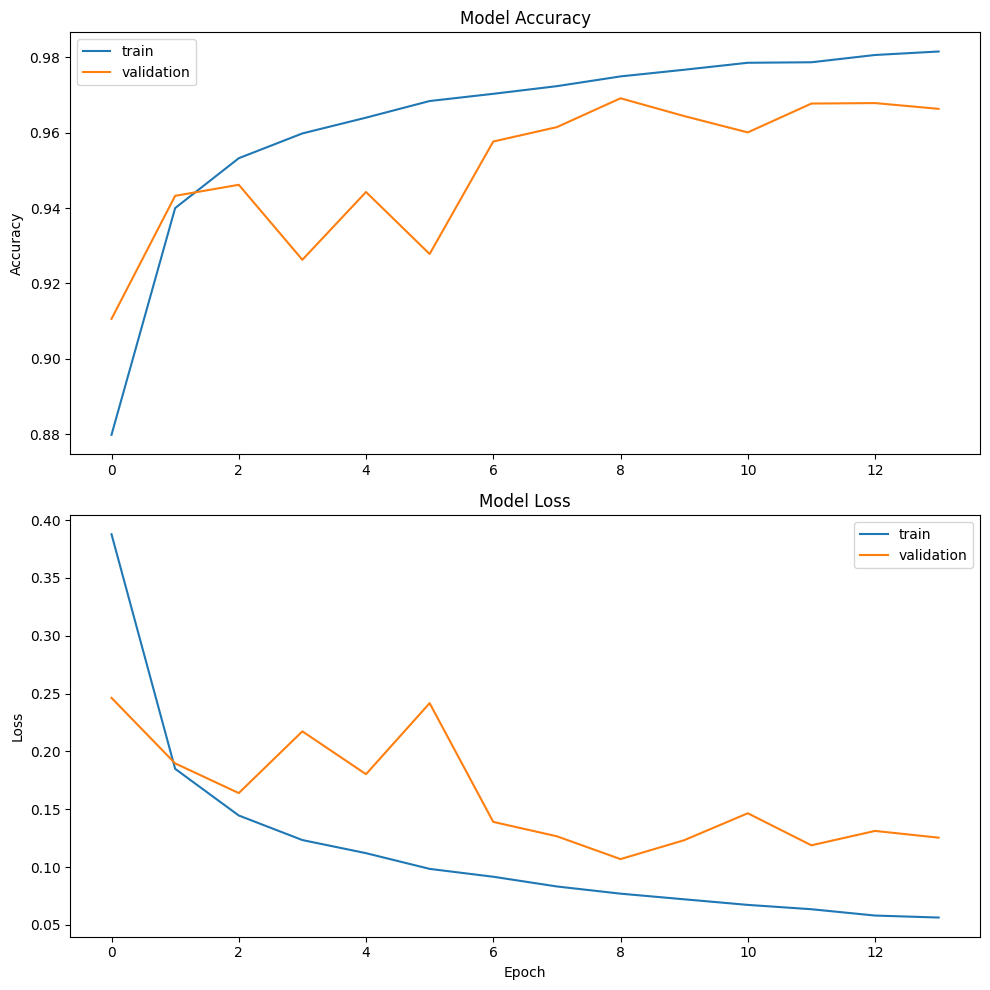

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

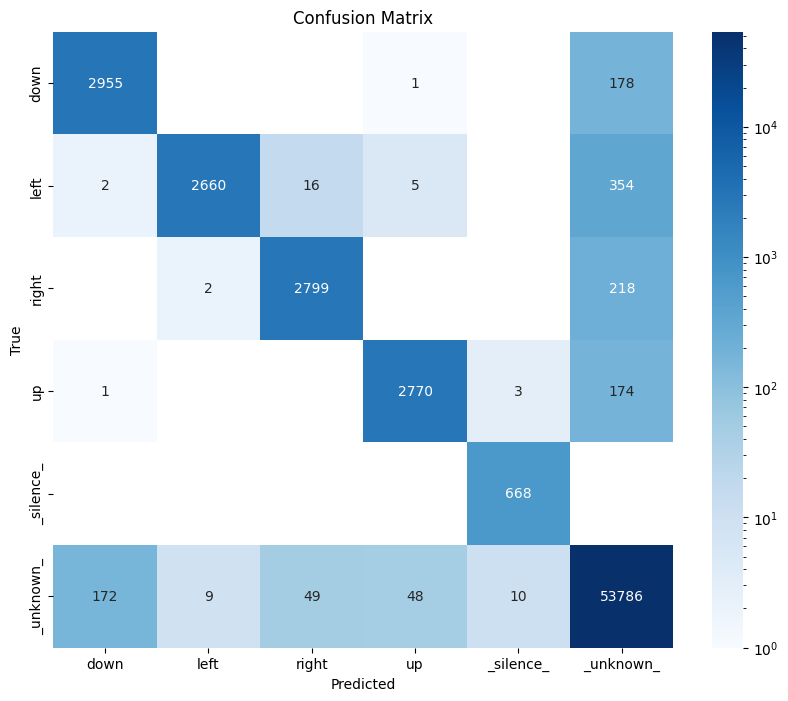

In [21]:
plot_history(history)
plot_confusion_matrix(model, preprocessed_train_ds, new_class_names)


In [ ]:
import tensorflow_hub as hub

def create_transfer_model(num_classes):
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    
    input_layer = tf.keras.layers.Input(shape=(16000,), dtype=tf.float32, name='audio')
    embeddings = yamnet_model(input_layer)['embeddings']
    dense = tf.keras.layers.Dense(128, activation='relu')(embeddings)
    dropout = tf.keras.layers.Dropout(0.5)(dense)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
def record_and_predict(model, duration=1, sample_rate=16000):
    pass

In [ ]:
def evaluate_model(model, preprocessed_test_ds=preprocessed_test_ds):
    _, accuracy = model.evaluate(preprocessed_test_ds)
    print(f"Test accuracy: {accuracy:.4f}")
    
    all_preds = []
    all_labels = []
    for x, y in preprocessed_test_ds:
        preds = model.predict(x)
        all_preds.append(preds)
        all_labels.append(y)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    from sklearn.metrics import classification_report
    pred_classes = np.argmax(all_preds, axis=1)
    true_classes = np.argmax(all_labels, axis=1)
    
    report = classification_report(true_classes, pred_classes, target_names=new_class_names)
    print(report)

In [25]:
evaluate_model(model)

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8961 - loss: 0.3324
Test accuracy: 0.8974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-04-09 21:11:36.719221: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-09 21:11:36.719259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9284510191020248239
2025-04-09 21:11:36.719286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17430468855062689173


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [ ]:
def create_rnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Reshape((-1, 1)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model